#### Práctica 2: Tipología y ciclo de vida de los datos
# xxxTÍTULO AQUÍ xxx
#### Autores: Víctor H. Ayala Sánchez y Clara M. Roca de la Concha

https://archive.ics.uci.edu/ml/datasets/heart+disease

# Tabla de contenidos

- 1. [Descripción del dataset](#1.-Descripción-del-dataset)
- 2. [Integración](#1.-Integración)
- 3. [Limpieza](#1.-Limpieza)
- 2. [Preprocesamiento](#2.-Preprocesamiento)

# Librerías

In [9]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Descripción del dataset

**¿Por qué es importante y qué pregunta/problema pretende responder?**			
Explicar la enfermedad cardiaca a partir de una serie de factores.xxxx
xxxExplicar.


# 2. Integración y selección de los datos de interés a analizar.
**Puede ser el resultado de adicionar diferentes datasets o una subselección útil de los datos originales, en base al objetivo que se quiera conseguir.**

# 3. Limpieza de los datos.
## 3.1. ¿Los datos contienen ceros o elementos vacíos? 
**Gestiona cada uno de estos casos.**
xxx Análisis de nulls etc. xxx

Cargamos los datos en objeto DataFrame de pandas

In [10]:
df = pd.read_csv("data/heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Realizamos un preprocesamiento, haciendo replace sobre las variables categóricas para poder analizar los datos

In [13]:
df = df.replace({
    'cp': {
        0: 'typical angina',
        1: 'atypical angina',
        2: 'non-anginal pain',
        3: 'asymptomatic'
        },
    'sex':{
        1:'Male',
        0:'Female'
    },
    'restecg':{
        0:'Normal',
        1:'ST-T wave abnormality',
        2:'Left ventricular hypertrophy'
    },
    'exng':{
        0:'Yes Angina',
        1:'No Angina'
    },
    'fbs':{
        0:'fastingBloodSugar_false',
        1:'fastingBloodSugar_true'  
    },
    'slp':{
        0:'upsloping',
        1:'flat',
        2:'downsloping'
    },
    'thall':{ 
        0 : np.NaN,
        1 : "fixed defect",
        2 : "normal",
        3 : "reversable defect"
    }
    
})

df.sample(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
24,40,Male,asymptomatic,140,199,fastingBloodSugar_false,ST-T wave abnormality,178,No Angina,1.4,downsloping,0,reversable defect,1
41,48,Male,atypical angina,130,245,fastingBloodSugar_false,Normal,180,Yes Angina,0.2,flat,0,normal,1
94,45,Female,atypical angina,112,160,fastingBloodSugar_false,ST-T wave abnormality,138,Yes Angina,0.0,flat,0,normal,1
281,52,Male,typical angina,128,204,fastingBloodSugar_true,ST-T wave abnormality,156,No Angina,1.0,flat,0,NaN,0
265,66,Male,typical angina,112,212,fastingBloodSugar_false,Normal,132,No Angina,0.1,downsloping,1,normal,0
5,57,Male,typical angina,140,192,fastingBloodSugar_false,ST-T wave abnormality,148,Yes Angina,0.4,flat,0,fixed defect,1
14,58,Female,asymptomatic,150,283,fastingBloodSugar_true,Normal,162,Yes Angina,1.0,downsloping,0,normal,1
2,41,Female,atypical angina,130,204,fastingBloodSugar_false,Normal,172,Yes Angina,1.4,downsloping,0,normal,1
211,61,Male,typical angina,120,260,fastingBloodSugar_false,ST-T wave abnormality,140,No Angina,3.6,flat,1,reversable defect,0
257,50,Male,typical angina,144,200,fastingBloodSugar_false,Normal,126,No Angina,0.9,flat,0,reversable defect,0


Una vez realizado el proceso de replace podemos notar que tenemos dos registros con valores aunsentes o perdidos en la variable **thall**

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    object 
 11  caa       303 non-null    int64  
 12  thall     301 non-null    object 
 13  output    303 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 33.3+ KB


Considerando que son solo 2 registros y que representan menos del 1% de los datos decidimos directamente eliminarlos del conjunto de datos. 

In [43]:
df.dropna(inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    object 
 2   cp        301 non-null    object 
 3   trtbps    301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    object 
 6   restecg   301 non-null    object 
 7   thalachh  301 non-null    int64  
 8   exng      301 non-null    object 
 9   oldpeak   301 non-null    float64
 10  slp       301 non-null    object 
 11  caa       301 non-null    int64  
 12  thall     301 non-null    object 
 13  output    301 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 35.3+ KB


## 3.2. Identifica y gestiona los valores extremos.
**Escribir aquí la solución.**


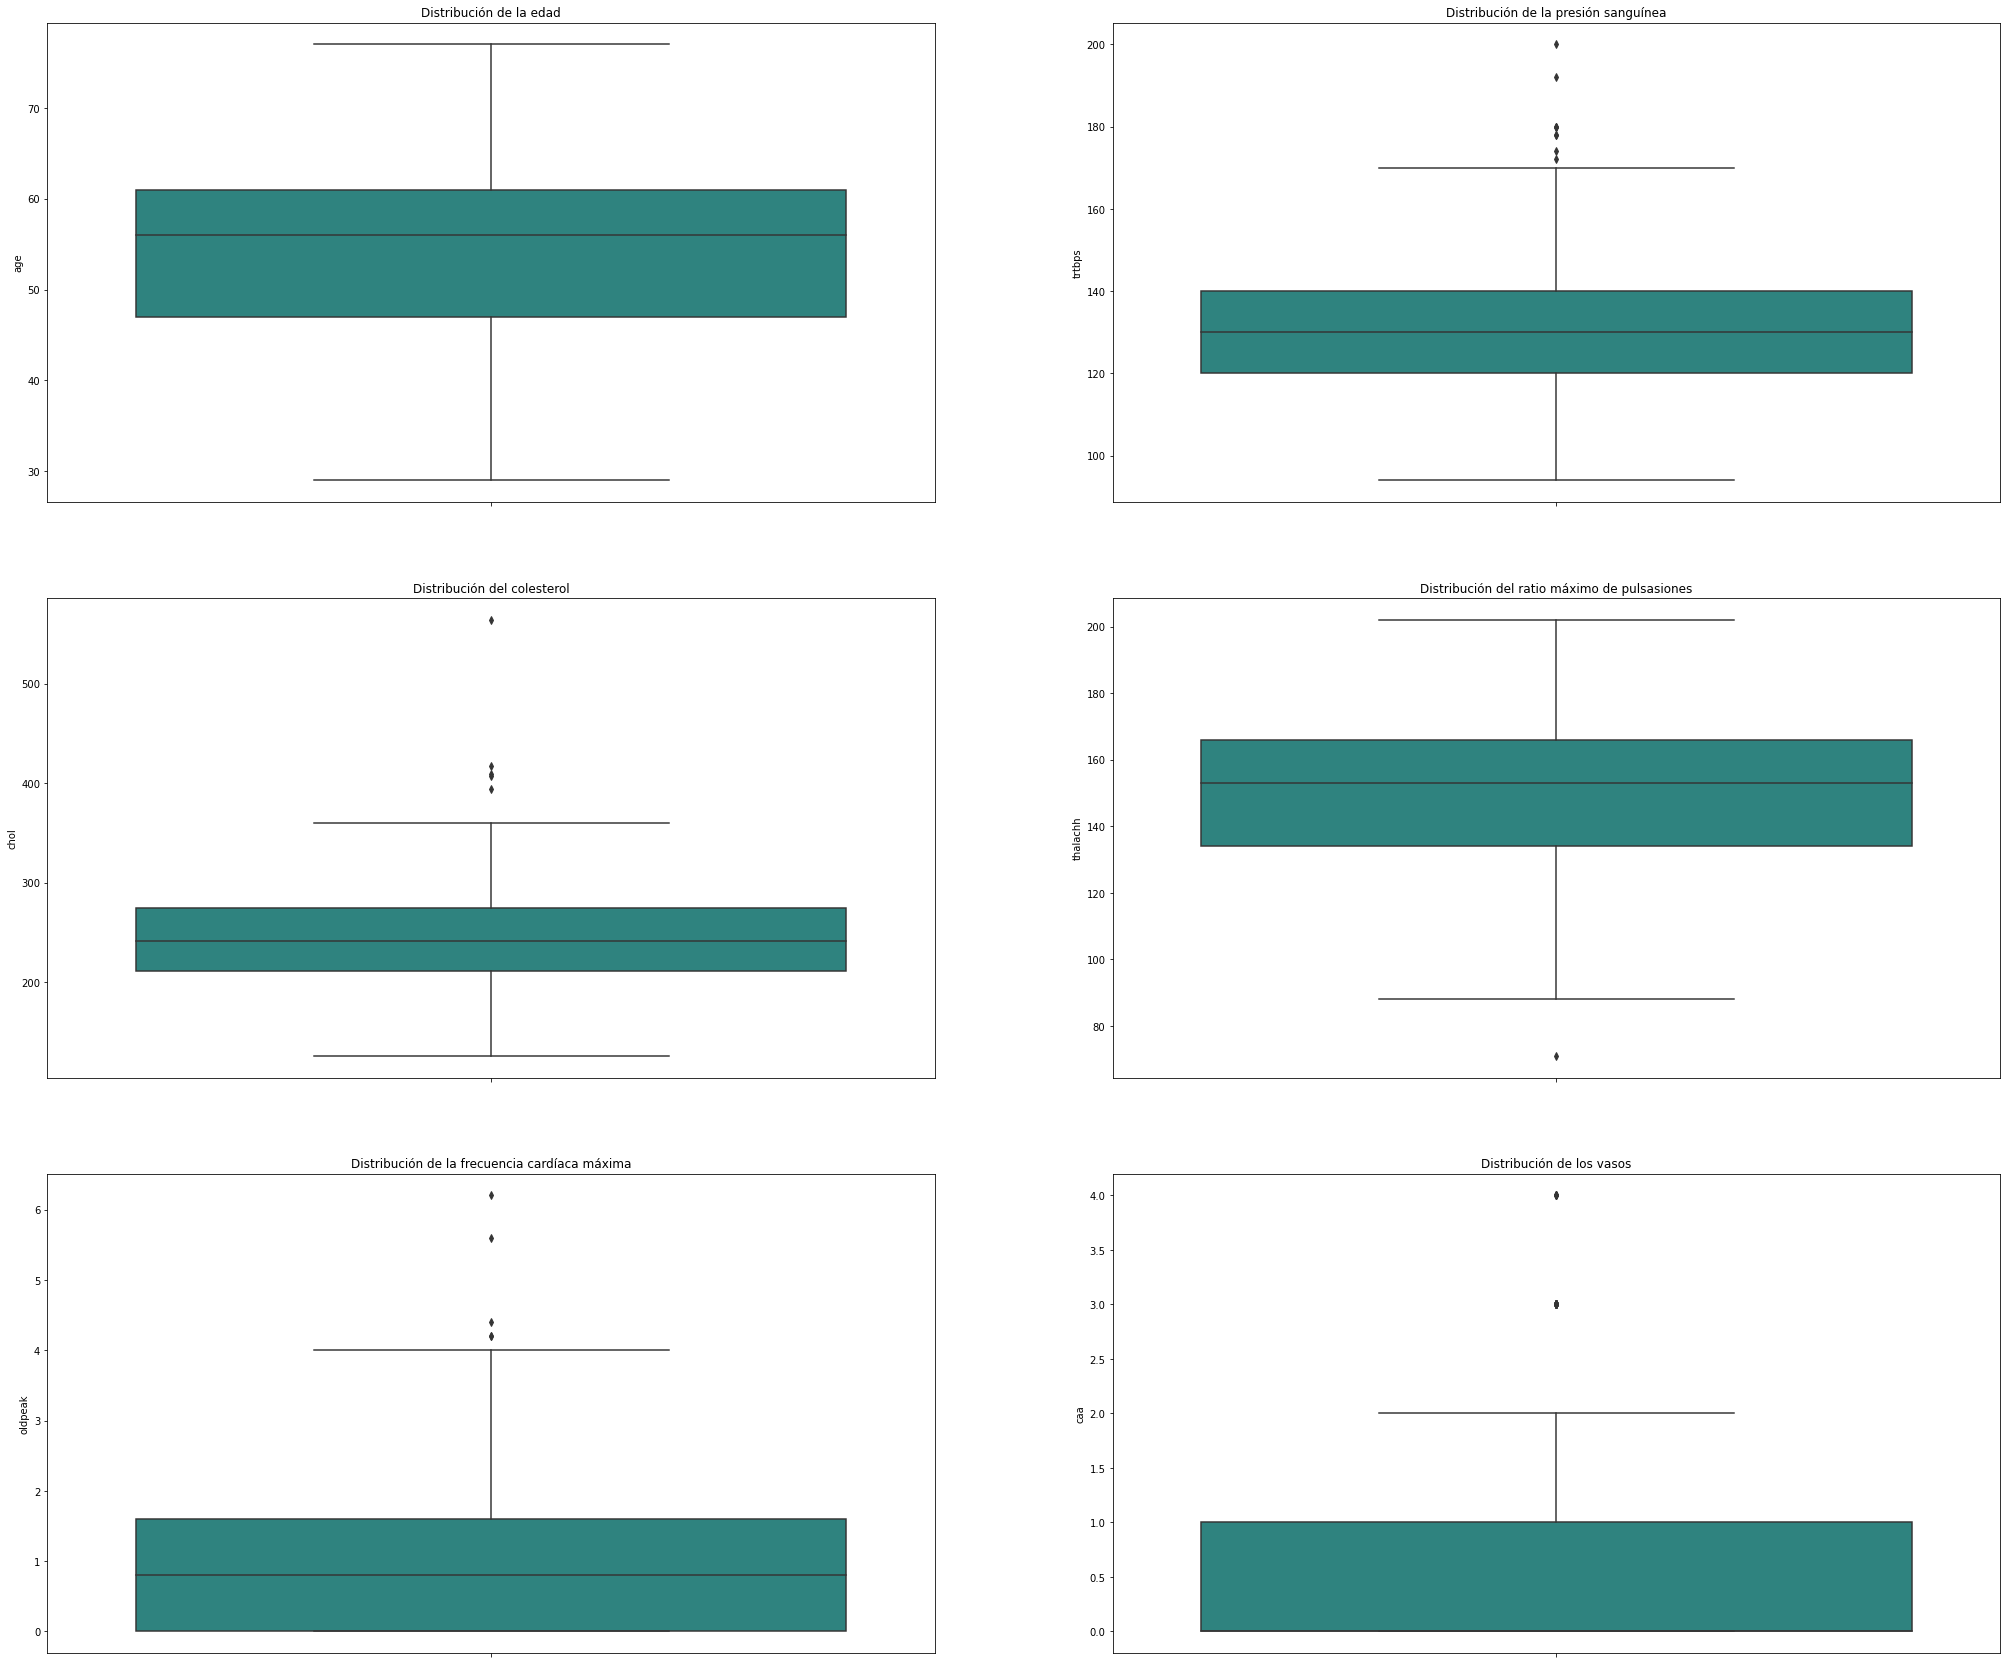

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(35,30))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trtbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')

sns.boxplot(ax=axes[1,0], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')
sns.boxplot(ax=axes[1,1], y="thalachh" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')

sns.boxplot(ax=axes[2,0], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[2,1], y="caa" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

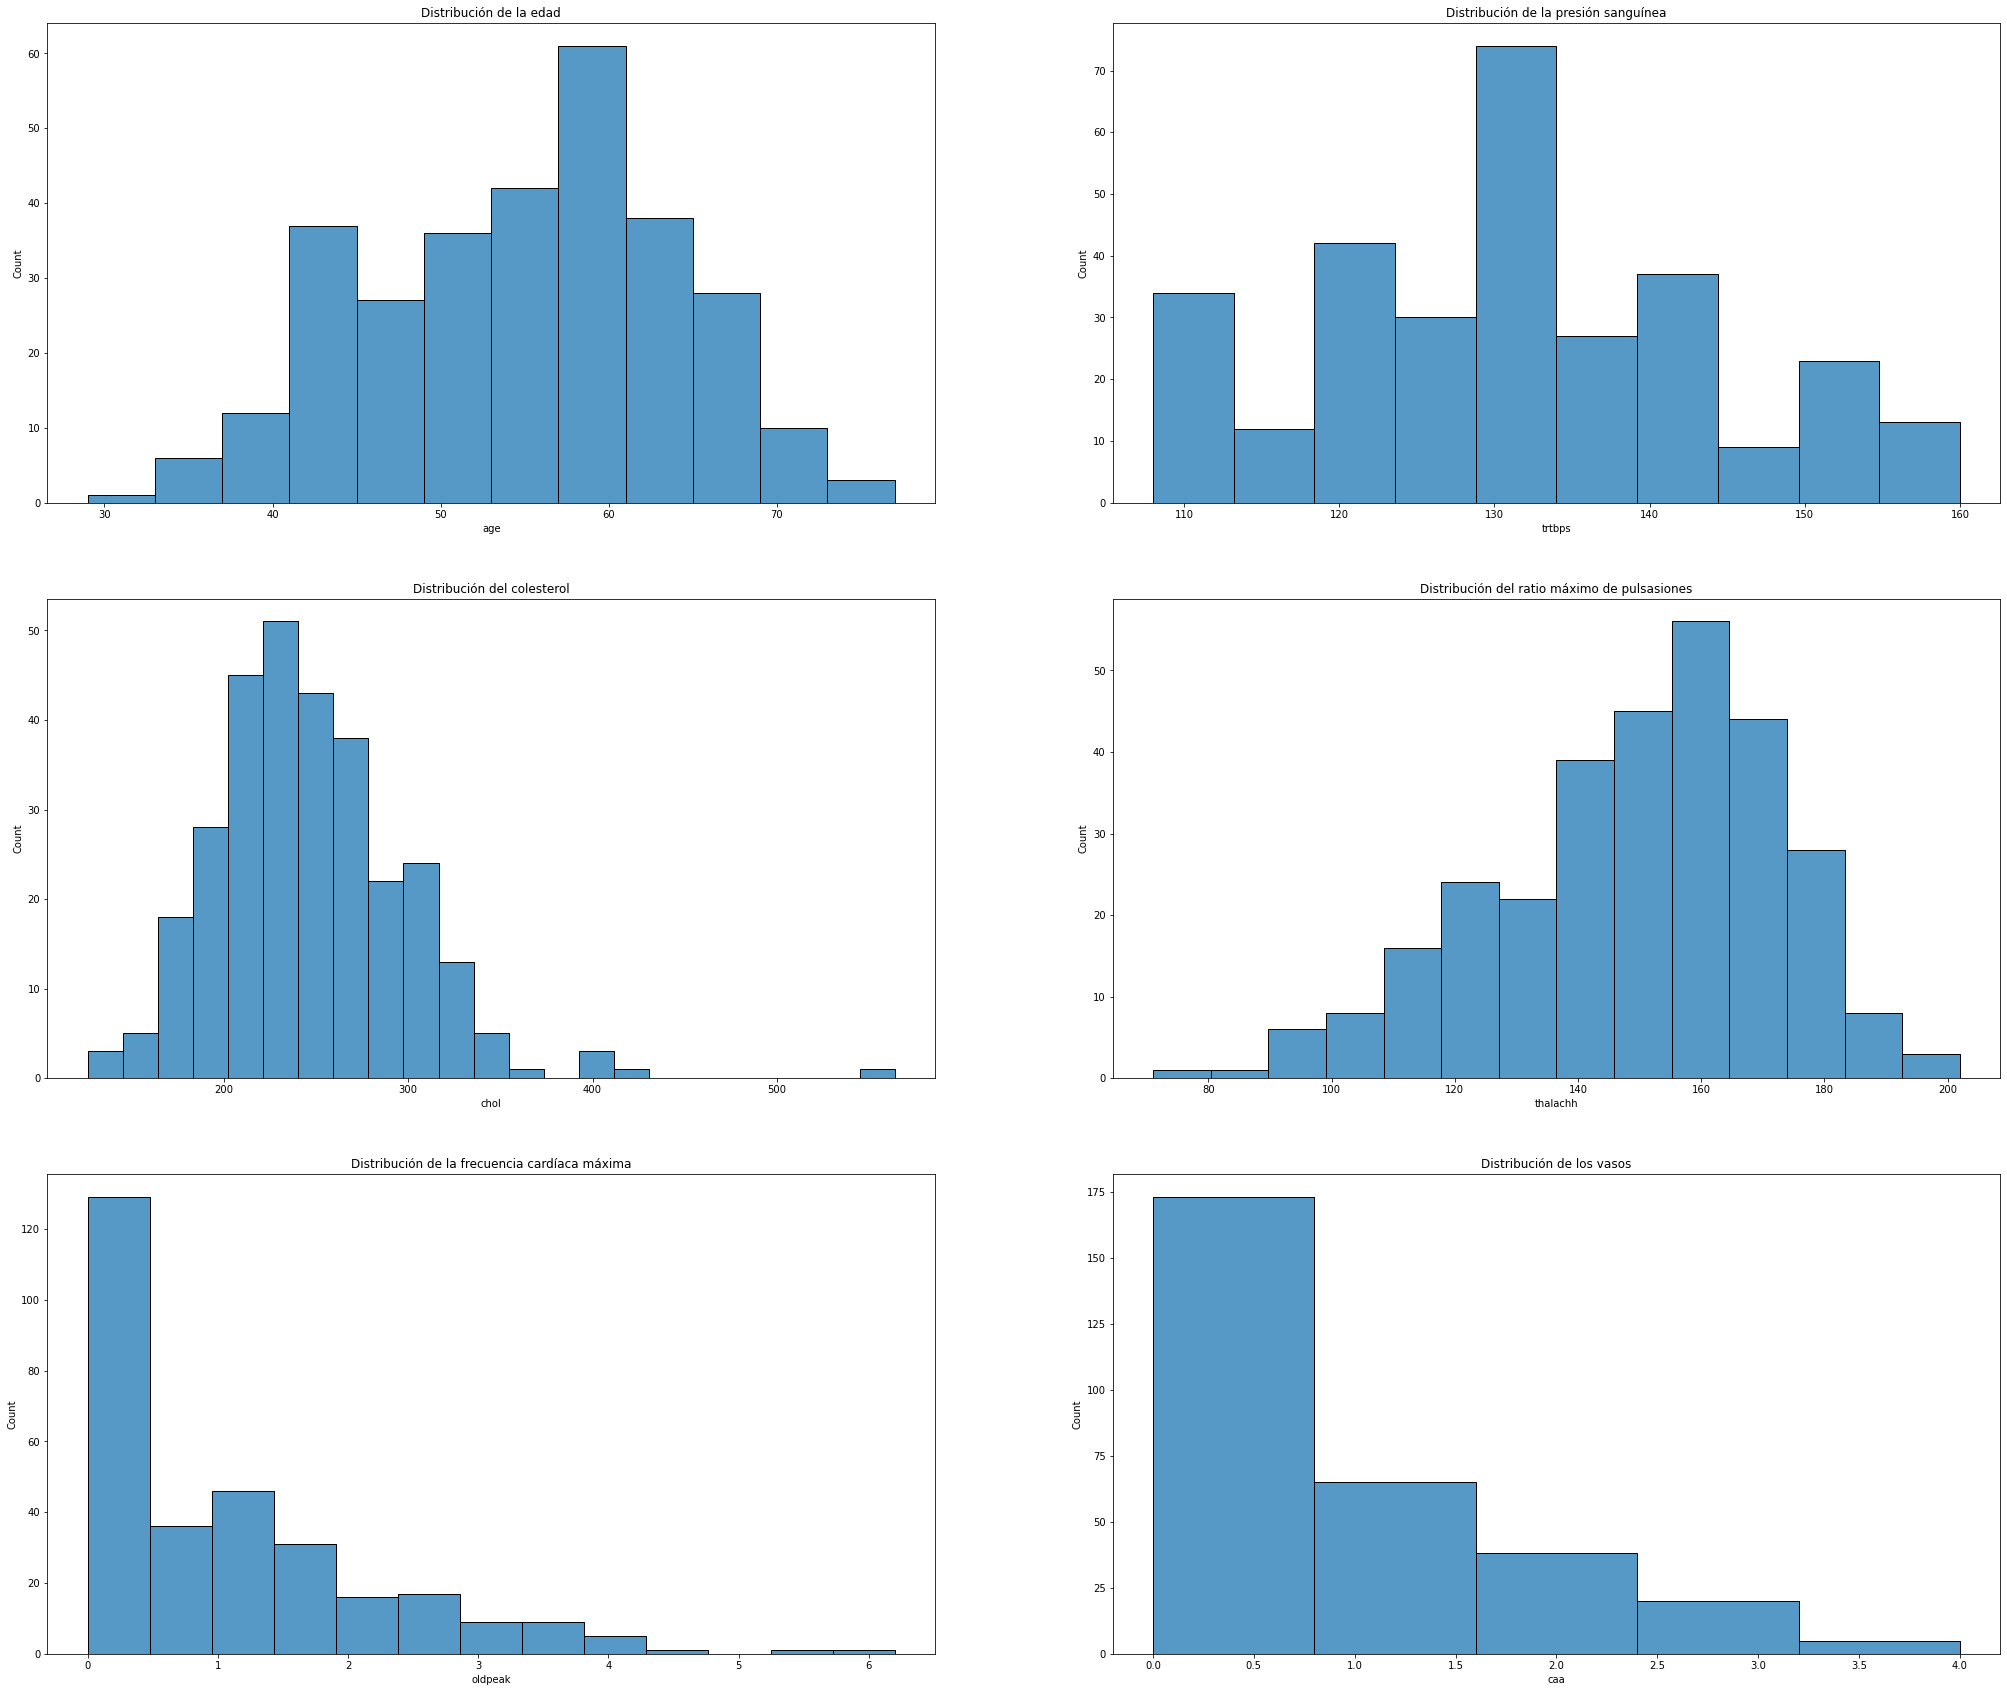

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(35,30))

sns.histplot(ax=axes[0,0], x="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.histplot(ax=axes[0,1], x="trtbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')

sns.histplot(ax=axes[1,0], x="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')
sns.histplot(ax=axes[1,1], x="thalachh" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')

sns.histplot(ax=axes[2,0], x="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.histplot(ax=axes[2,1], x="caa" ,palette="viridis", data=df, bins=5).set(title='Distribución de los vasos')

plt.show()

Definimos la siguiente función para reemplazar aquellos valores que se encuentren por encima del percentil 95 o por debajo del percentil 5, considerados como valores extremos, por la mediana.

In [67]:
df.describe()

,age,trtbps,chol,thalachh,oldpeak,caa,output
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.378738,130.681063,246.504983,149.740864,1.043189,0.734219,0.544850
std,9.110950,12.712380,51.915998,22.891031,1.163384,1.024268,0.498814
min,29.000000,108.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,211.000000,134.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000
max,77.000000,160.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [62]:
def replaceOuliers(column):
    """
    """
    colReplace = np.array(column)
    median = np.median(column)
    
    upper =  np.percentile(np.array(column),95)
    lower =  np.percentile(np.array(column),5)
    
    colReplace[colReplace[:] > upper] = median
    colReplace[colReplace[:] < lower] = median
    return list(colReplace)

In [63]:
df["trtbps"] = replaceOuliers(list(df["trtbps"]))
df["chol"] = replaceOuliers(list(df["chol"]))



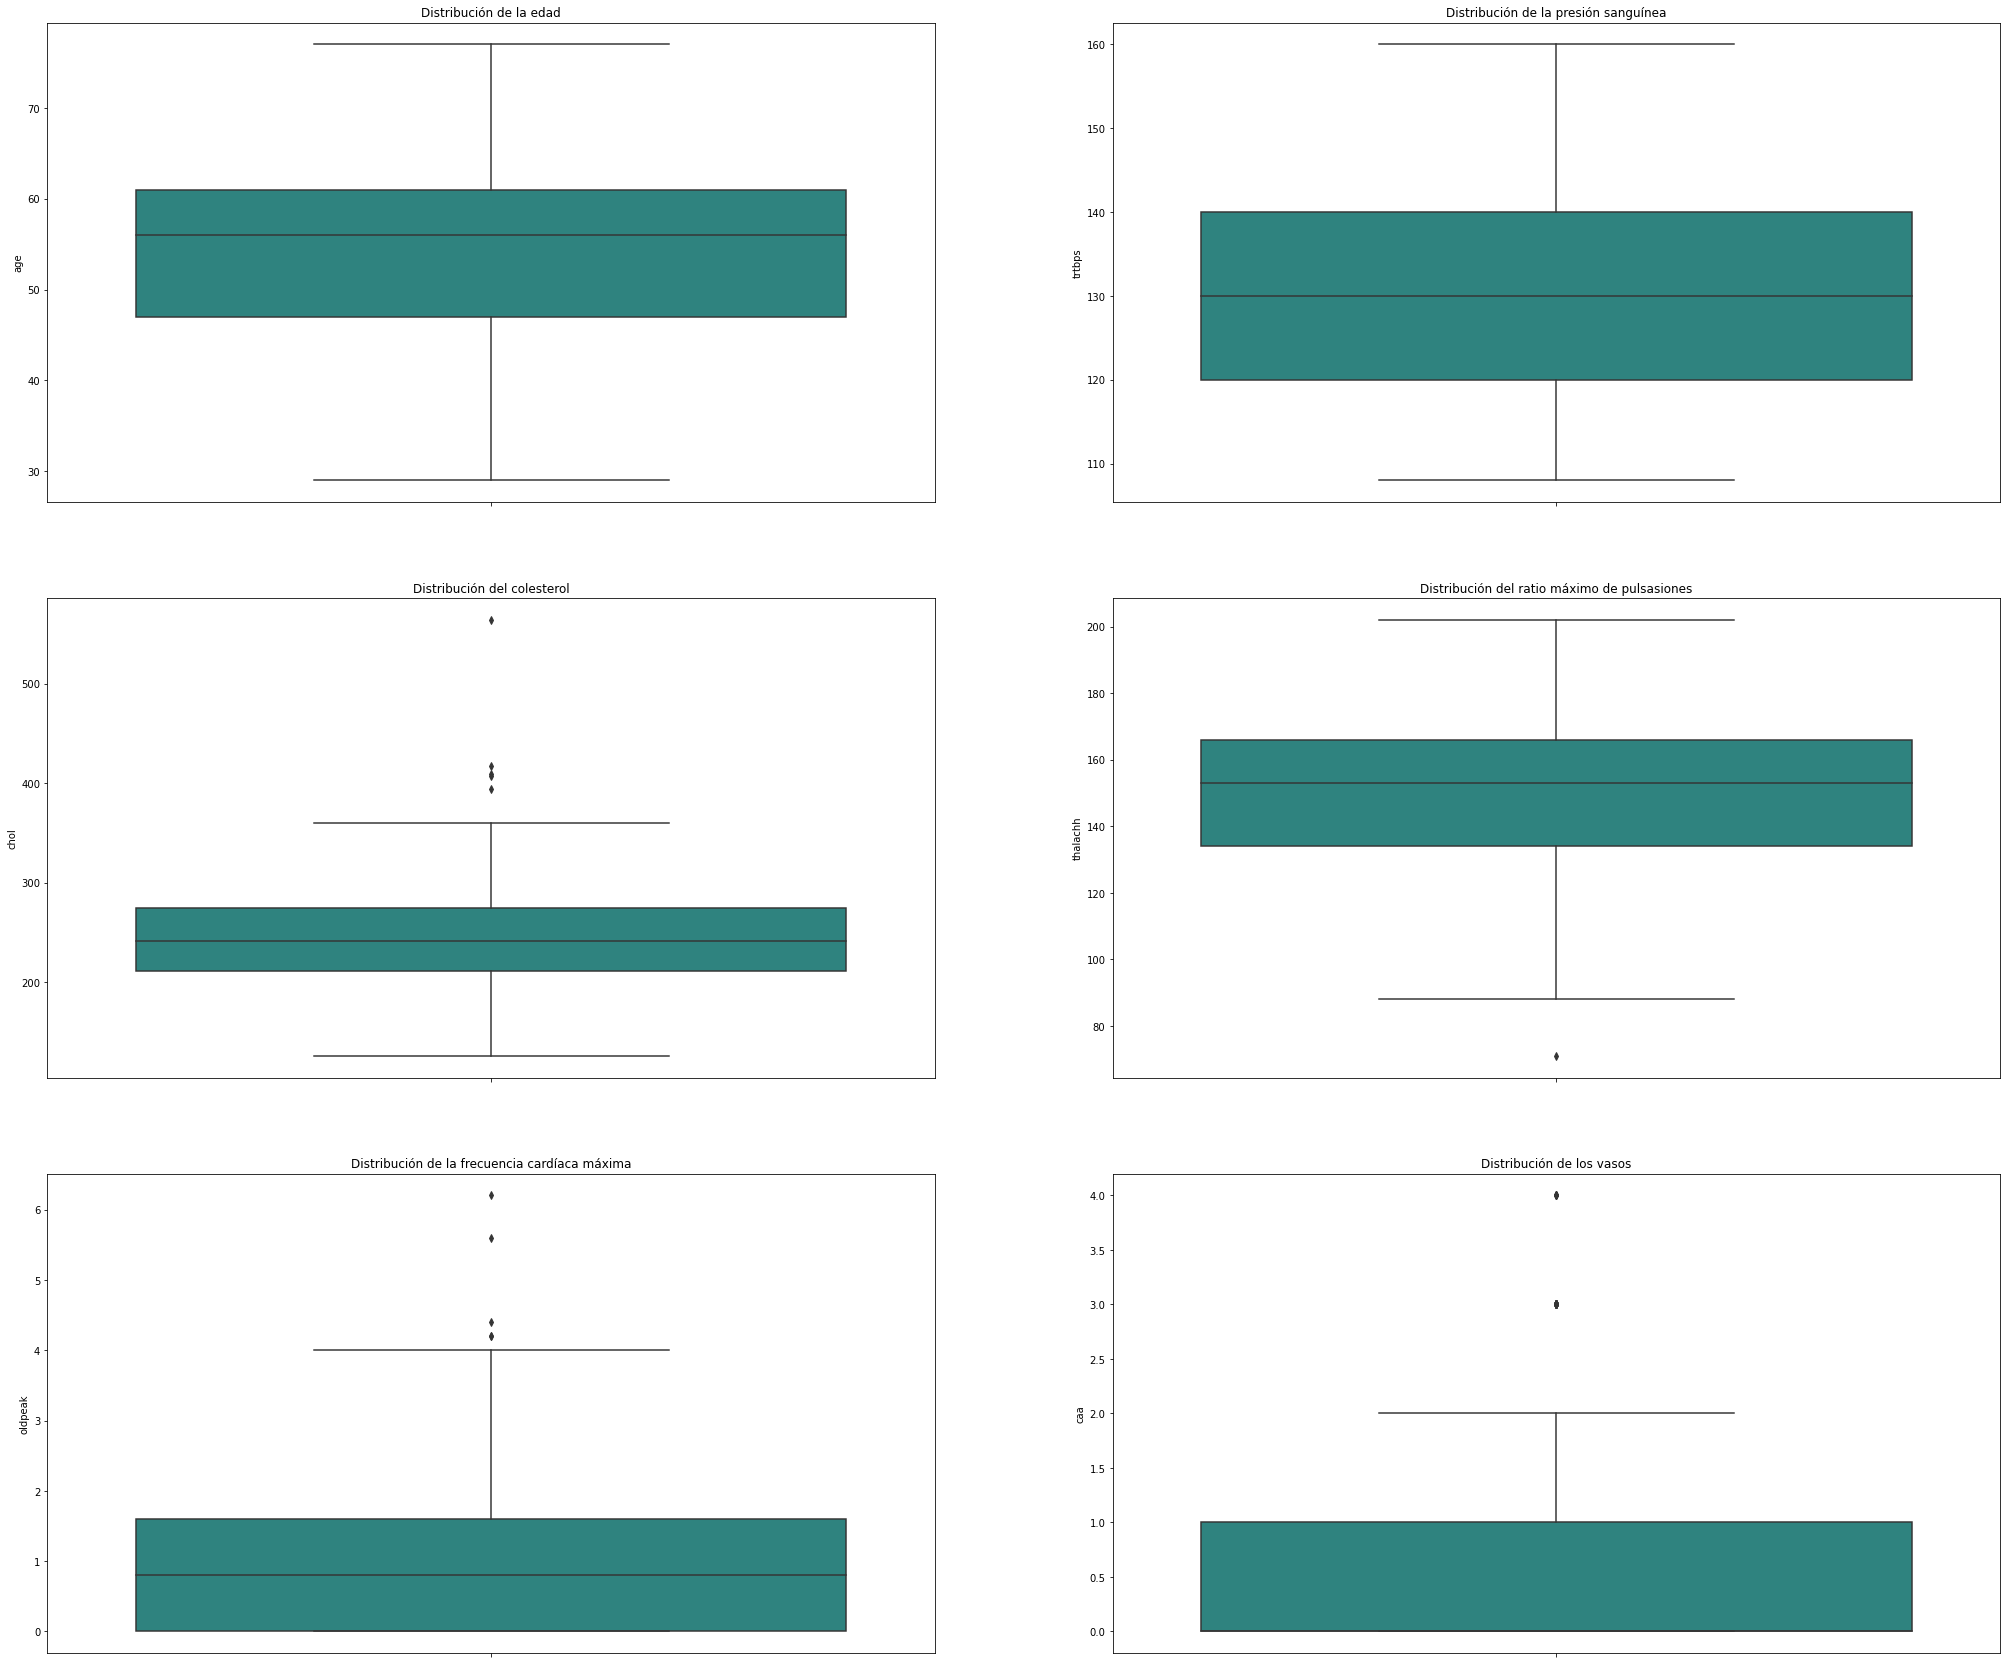

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(35,30))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trtbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')

sns.boxplot(ax=axes[1,0], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')
sns.boxplot(ax=axes[1,1], y="thalachh" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')

sns.boxplot(ax=axes[2,0], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[2,1], y="caa" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

In [ ]:
y="trtbps", palette="viridis", data=df

Realizamos un análisis exploratorio de datos:


Revisamos los estadísticos descriptivos de las variables cuantitativas

In [ ]:
df.describe()

Analizamos los mismos estadísticos descriptivos pero esta vez haciendo distinción entre los grupos de enfermos y no enfermos del conjunto de datos

In [ ]:
df[["age","trtbps","chol","thalachh","oldpeak","caa","thall","output"]].groupby("output").describe().T

# 4. Análisis de los datos.
## 4.1. Selección de los grupos de datos que se quieren analizar/comparar 
**(p.ej., si se van a comparar grupos de datos, ¿cuáles son estos grupos y
qué tipo de análisis se van a aplicar?)**

## 4.2. Comprobación de la normalidad y homogeneidad de la varianza.

## 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos. 
**En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.**



# 5. Representación gráfica
**Representación de los resultados a partir de tablas y gráficas. Este apartado se puede responder a lo largo de la práctica, sin necesidad de concentrar todas las representaciones en este punto de la práctica.**

xxx Resuelto a lo largo de la práctica xx

# 6. Resolución del problema
**A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?**

# 7. Código
**Hay que adjuntar el código, preferiblemente en R, con el que se ha realizado la limpieza, análisis y representación de los datos. Si lo preferís, también podéis trabajar en Python.**

xx El código se ha ido viendo a lo largo de la práctica xx

# 8. Vídeo
**Realizar un breve vídeo explicativo de la práctica (máximo 10 minutos), donde ambos integrantes del equipo expliquen con sus propias palabras el desarrollo de la práctica, basándose en las preguntas del enunciado para justificar y explicar el código desarrollado. Este vídeo se deberá entregar a través de un enlace al Google Drive de la UOC (https://drive.google.com/...), junto con enlace al repositorio Git entregado.**

# Contribuciones

In [5]:
contribuciones = pd.DataFrame()
contribuciones['Contribuciones'] = ['Investigación previa', 'Redacción de las respuestas', 'Desarrollo del código', 'Participación en el vídeo']
contribuciones['Firma'] = ['Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca']
contribuciones

,Contribuciones,Firma
0,Investigación previa,"Víctor H. Ayala, Clara Roca"
1,Redacción de las respuestas,"Víctor H. Ayala, Clara Roca"
2,Desarrollo del código,"Víctor H. Ayala, Clara Roca"
3,Participación en el vídeo,"Víctor H. Ayala, Clara Roca"


***

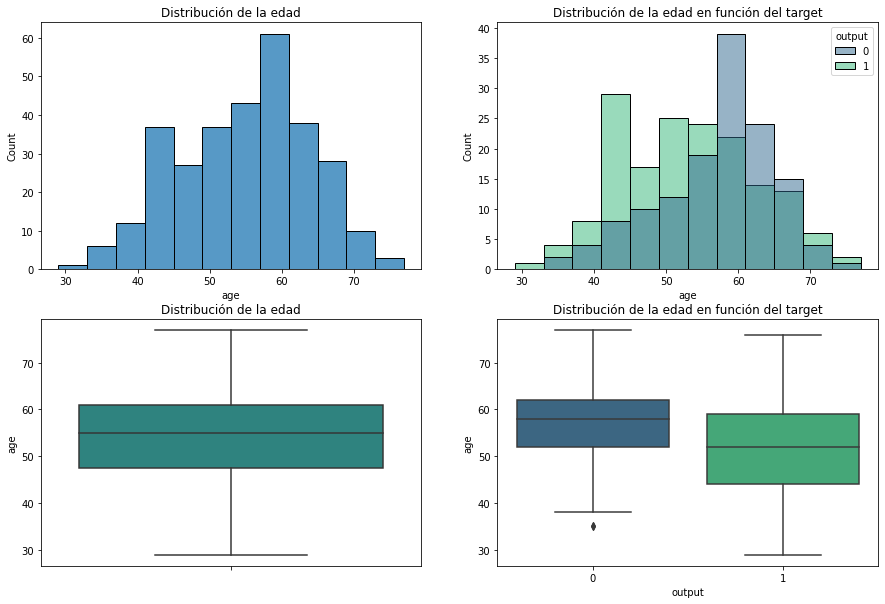

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.histplot(ax=axes[0,0], x="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.histplot(ax=axes[0,1], x="age", hue="output",palette="viridis", data=df).set(title='Distribución de la edad en función del target')

sns.boxplot(ax=axes[1,0], y="age" ,palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[1,1], y="age",x ="output", palette="viridis", data=df).set(title='Distribución de la edad en función del target')

plt.show()

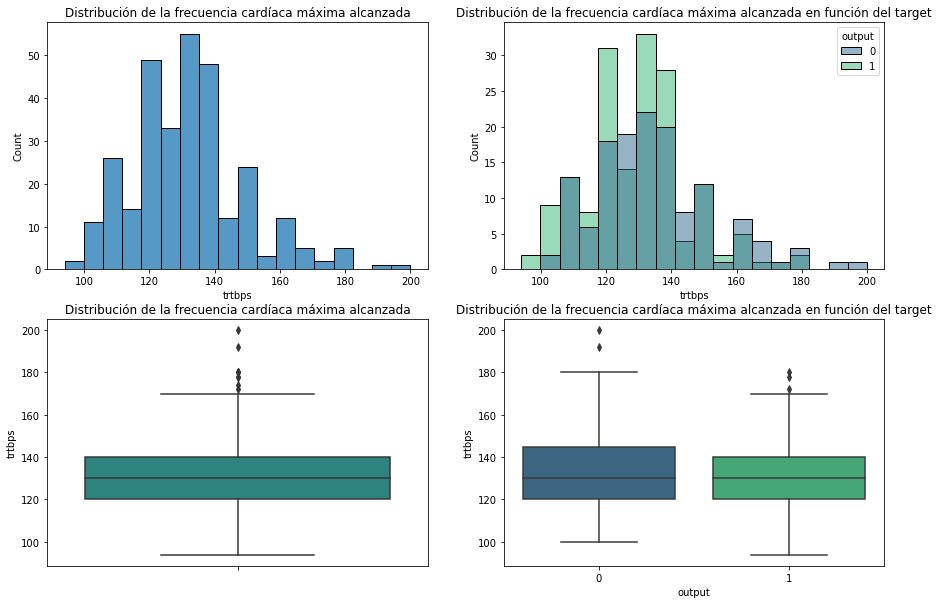

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.histplot(ax=axes[0,0], x="trtbps", palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima alcanzada')
sns.histplot(ax=axes[0,1], x="trtbps", hue="output",palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima alcanzada en función del target')

sns.boxplot(ax=axes[1,0], y="trtbps" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima alcanzada')
sns.boxplot(ax=axes[1,1], y="trtbps",x ="output", palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima alcanzada en función del target')

plt.show()

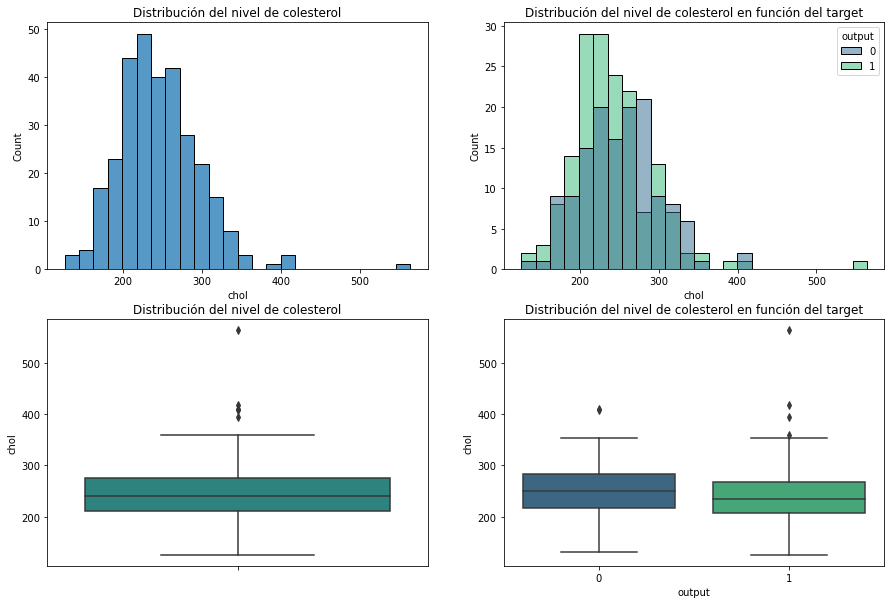

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.histplot(ax=axes[0,0], x="chol", palette="viridis", data=df).set(title='Distribución del nivel de colesterol')
sns.histplot(ax=axes[0,1], x="chol", hue="output",palette="viridis", data=df).set(title='Distribución del nivel de colesterol en función del target')

sns.boxplot(ax=axes[1,0], y="chol" ,palette="viridis", data=df).set(title='Distribución del nivel de colesterol')
sns.boxplot(ax=axes[1,1], y="chol",x ="output", palette="viridis", data=df).set(title='Distribución del nivel de colesterol en función del target')

plt.show()